In [1]:
# === Import libraries ===
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the generator metadata
registration_file = 'NEM_Registration_and_Exemption_List.xlsx'
reg_df = pd.read_excel(registration_file, sheet_name='PU and Scheduled Loads', engine='openpyxl')

# Clean column names
reg_df.columns = reg_df.columns.str.replace('\xa0', ' ', regex=True).str.strip()

# Normalize columns for filtering
reg_df['Fuel Source - Primary'] = reg_df['Fuel Source - Primary'].str.upper()
reg_df['Dispatch Type'] = reg_df['Dispatch Type'].str.upper()

# Filter for renewables
renewables = ['SOLAR', 'WIND', 'HYDRO']
reg_df_filtered = reg_df[
    (reg_df['Fuel Source - Primary'].isin(renewables)) &
    (reg_df['Dispatch Type'] == 'GENERATING UNIT') &
    (reg_df['DUID'].notna())
]

# Keep only necessary columns and rename
reg_df_filtered = reg_df_filtered[[
    'DUID', 'Fuel Source - Primary', 'Region', 'Max Cap generation (MW)', 'Station Name']]
reg_df_filtered.columns = ['DUID', 'FuelType', 'Region', 'MaxCapacityMW', 'StationName']

# Clean values
reg_df_filtered = reg_df_filtered.dropna(subset=['Region', 'MaxCapacityMW'])
reg_df_filtered['MaxCapacityMW'] = pd.to_numeric(reg_df_filtered['MaxCapacityMW'], errors='coerce')
reg_df_filtered = reg_df_filtered[reg_df_filtered['MaxCapacityMW'] > 0]
reg_df_filtered = reg_df_filtered.drop_duplicates(subset='DUID')

# ===  Validate using DUDETAILSUMMARY ===
du_df = pd.read_csv('DUDETAILSUMMARY_2025_02.csv', header=1, encoding='ISO-8859-1')
du_df_clean = du_df[['DUID', 'REGIONID', 'DISPATCHTYPE']].drop_duplicates()
du_df_clean = du_df_clean[du_df_clean['DISPATCHTYPE'].str.upper() == 'GENERATOR']

# Merge to retain only valid DUIDs
reg_df_filtered = pd.merge(reg_df_filtered, du_df_clean[['DUID']], on='DUID', how='inner')

# Save cleaned generator metadata
reg_df_filtered.to_csv('renewable_generators_metadata.csv', index=False)

# === Load and clean SCADA data ===
scada_files = [
    'DISPATCH_UNIT_SCADA_Sept24.CSV',
    'DISPATCH_UNIT_SCADA_Oct24.CSV',
    'DISPATCH_UNIT_SCADA_Nov24.CSV',
    'DISPATCH_UNIT_SCADA_Dec24.CSV',
    'DISPATCH_UNIT_SCADA_Jan25.CSV',
    'DISPATCH_UNIT_SCADA_Feb25.CSV'
]

scada_list = []
for file in scada_files:
    print("Loading SCADA:", file)
    df = pd.read_csv(file, header=1, encoding='ISO-8859-1')
    df = df[['SETTLEMENTDATE', 'DUID', 'SCADAVALUE']]
    df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
    df = df[df['DUID'].isin(reg_df_filtered['DUID'])]
    scada_list.append(df)

scada_all = pd.concat(scada_list)
scada_merged = pd.merge(scada_all, reg_df_filtered[['DUID', 'FuelType', 'Region']], on='DUID', how='left')
scada_merged = scada_merged.dropna()

scada_grouped = scada_merged.groupby(['SETTLEMENTDATE', 'Region', 'FuelType'])['SCADAVALUE'].sum().reset_index()
scada_pivot = scada_grouped.pivot(index=['SETTLEMENTDATE', 'Region'], columns='FuelType', values='SCADAVALUE').fillna(0).reset_index()
scada_pivot.columns.name = None
scada_pivot = scada_pivot.rename(columns={'SOLAR': 'SolarMW', 'WIND': 'WindMW', 'HYDRO': 'HydroMW'})

# === Load and clean DISPATCHPRICE data ===
price_files = [
    'DISPATCHPRICE_Sept24.CSV',
    'DISPATCHPRICE_Oct24.CSV',
    'DISPATCHPRICE_Nov24.CSV',
    'DISPATCHPRICE_Dec24.CSV',
    'DISPATCHPRICE_Jan25.CSV',
    'DISPATCHPRICE_Feb25.CSV'
]

price_list = []
for file in price_files:
    print("Loading PRICE:", file)
    df = pd.read_csv(file, header=1, encoding='ISO-8859-1')
    df.columns = df.columns.str.replace('\xa0', ' ', regex=True).str.strip()
    if all(col in df.columns for col in ['SETTLEMENTDATE', 'REGIONID', 'RRP']):
        df = df[['SETTLEMENTDATE', 'REGIONID', 'RRP']]
        df = df.rename(columns={'REGIONID': 'Region'})
        df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
        price_list.append(df)

price_all = pd.concat(price_list)

# ===  Merge SCADA and price data ===
final_data = pd.merge(scada_pivot, price_all, on=['SETTLEMENTDATE', 'Region'], how='inner')
final_data.to_csv('scada_price_fueltype.csv', index=False)
print("Final dataset saved. Preview:")
print(final_data.head())


Loading SCADA: DISPATCH_UNIT_SCADA_Sept24.CSV
Loading SCADA: DISPATCH_UNIT_SCADA_Oct24.CSV
Loading SCADA: DISPATCH_UNIT_SCADA_Nov24.CSV


/var/folders/yb/vdyyl1fd41v4vtqyhd2xcpqw0000gn/T/ipykernel_30434/1477618858.py:55: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, header=1, encoding='ISO-8859-1')


Loading SCADA: DISPATCH_UNIT_SCADA_Dec24.CSV
Loading SCADA: DISPATCH_UNIT_SCADA_Jan25.CSV
Loading SCADA: DISPATCH_UNIT_SCADA_Feb25.CSV
Loading PRICE: DISPATCHPRICE_Sept24.CSV
Loading PRICE: DISPATCHPRICE_Oct24.CSV
Loading PRICE: DISPATCHPRICE_Nov24.CSV
Loading PRICE: DISPATCHPRICE_Dec24.CSV
Loading PRICE: DISPATCHPRICE_Jan25.CSV
Loading PRICE: DISPATCHPRICE_Feb25.CSV
Final dataset saved. Preview:
       SETTLEMENTDATE Region      HydroMW   SolarMW       WindMW       RRP
0 2024-09-01 00:05:00   NSW1  1144.108020  0.023056  1777.561546  57.00002
1 2024-09-01 00:05:00   QLD1   276.002500  0.272640   244.368680  96.75000
2 2024-09-01 00:05:00    SA1     0.000000  0.000000  1643.185150 -43.18425
3 2024-09-01 00:05:00   TAS1   471.541268  0.000000   247.628740 -47.20338
4 2024-09-01 00:05:00   VIC1    -1.000000  0.000000  2817.227610 -43.89000


Negative generation values have been replaced with zero, and flags (Neg_Hydro, Neg_Solar, Neg_Wind) have been added to preserve traceability (in the below code), further added useful time-based features: Hour, Month, DayOfWeek

In [3]:
# Load the dataset
df = pd.read_csv('scada_price_fueltype.csv', parse_dates=['SETTLEMENTDATE'])

In [4]:
# === Flag negative generation values ===
df['Neg_Hydro'] = df['HydroMW'] < 0
df['Neg_Solar'] = df['SolarMW'] < 0
df['Neg_Wind'] = df['WindMW'] < 0

# === Replace negative generation values with zero ===
df[['HydroMW', 'SolarMW', 'WindMW']] = df[['HydroMW', 'SolarMW', 'WindMW']].clip(lower=0)

# ===  Add time-based features ===
df['Hour'] = df['SETTLEMENTDATE'].dt.hour
df['Month'] = df['SETTLEMENTDATE'].dt.month
df['DayOfWeek'] = df['SETTLEMENTDATE'].dt.dayofweek  # Monday=0, Sunday=6

# === Save cleaned dataset ===
df.to_csv('scada_price_fueltype_cleaned.csv', index=False)
print("Cleaned dataset saved as 'scada_price_fueltype_cleaned.csv'")


Cleaned dataset saved as 'scada_price_fueltype_cleaned.csv'


EDA

Daily Total Renewable Generation vs RRP

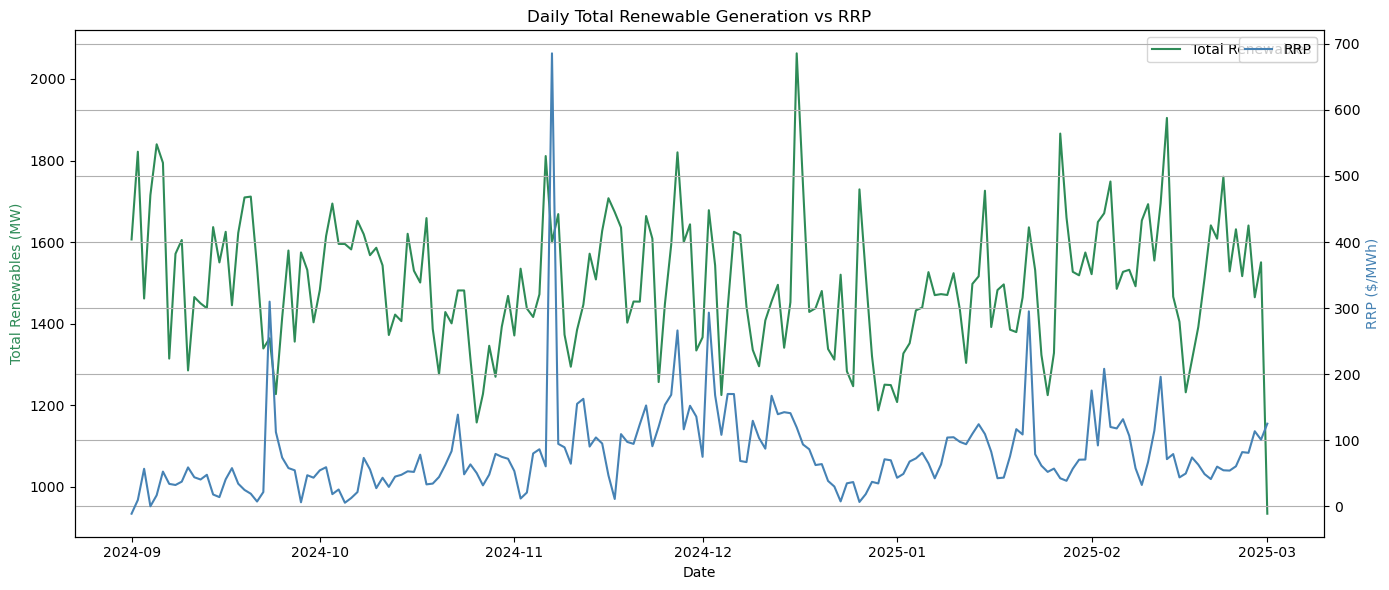

In [5]:
# Add a Date column
df['Date'] = df['SETTLEMENTDATE'].dt.date

# Calculate Total Renewables
df['TotalRenewables'] = df['SolarMW'] + df['WindMW'] + df['HydroMW']

# Group by Date and calculate daily average
daily_avg = df.groupby('Date')[['TotalRenewables', 'RRP']].mean().reset_index()

# Plot
plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()
sns.lineplot(data=daily_avg, x='Date', y='TotalRenewables', ax=ax1, color='seagreen', label='Total Renewables')
sns.lineplot(data=daily_avg, x='Date', y='RRP', ax=ax2, color='steelblue', label='RRP')
ax1.set_ylabel('Total Renewables (MW)', color='seagreen')
ax2.set_ylabel('RRP ($/MWh)', color='steelblue')
plt.title('Daily Total Renewable Generation vs RRP')
plt.grid(True)
plt.tight_layout()
plt.show()


Daily Average Renewable Generation vs RRP

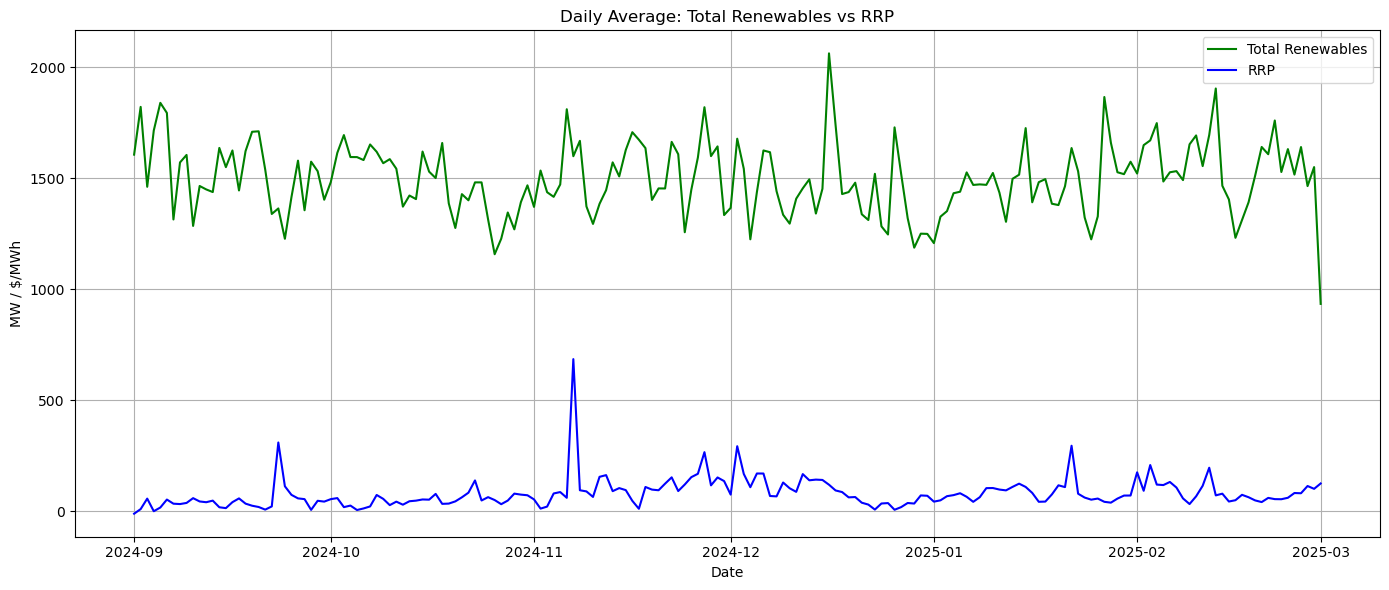

In [6]:
df['Date'] = df['SETTLEMENTDATE'].dt.date
df['TotalRenewables'] = df[['SolarMW', 'WindMW', 'HydroMW']].sum(axis=1)
df_daily = df.groupby('Date')[['SolarMW', 'WindMW', 'HydroMW', 'TotalRenewables', 'RRP']].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_daily, x='Date', y='TotalRenewables', label='Total Renewables', color='green')
sns.lineplot(data=df_daily, x='Date', y='RRP', label='RRP', color='blue')
plt.title('Daily Average: Total Renewables vs RRP')
plt.ylabel('MW / $/MWh')
plt.grid(True)
plt.tight_layout()
plt.show()


Daily Renewable Generation (Solar, Wind, Hydro)

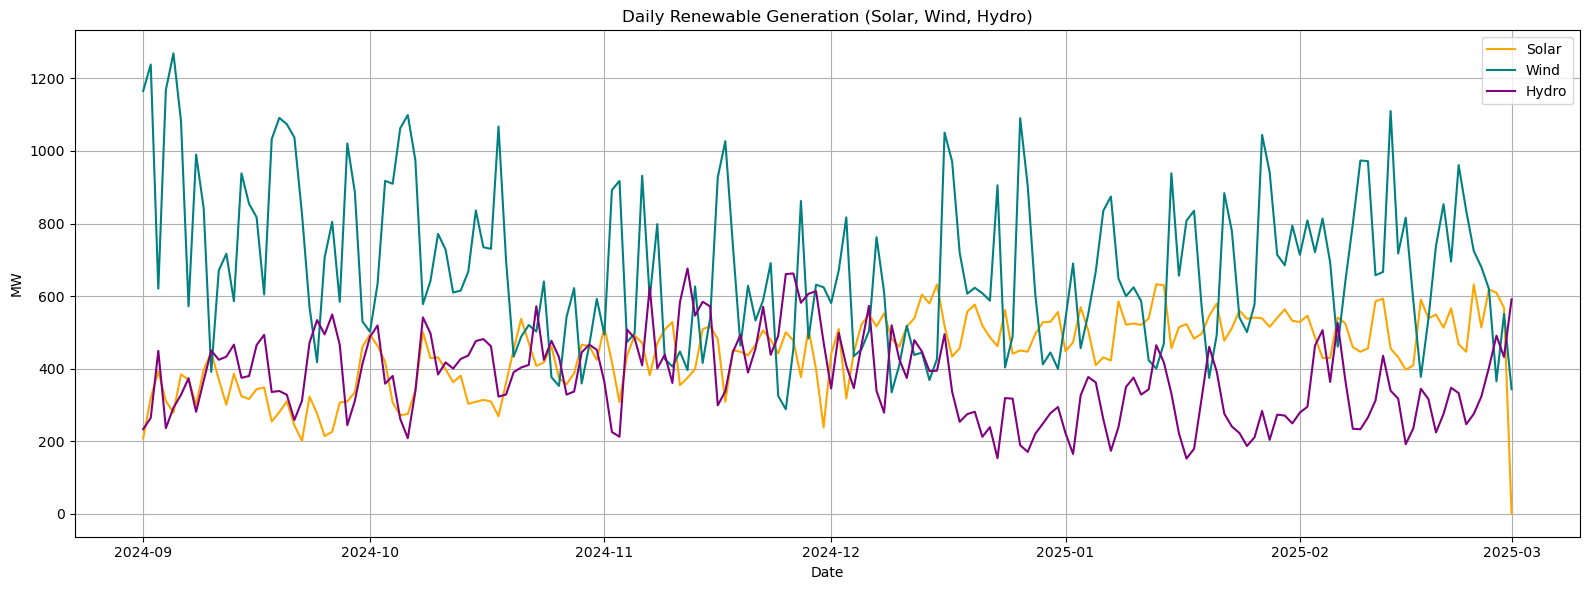

In [7]:
# Extract date only
df['Date'] = df['SETTLEMENTDATE'].dt.date

# Group by Date and compute daily average generation
daily_gen = df.groupby('Date')[['SolarMW', 'WindMW', 'HydroMW']].mean().reset_index()

# Plot daily generation for each renewable type
plt.figure(figsize=(16, 6))
sns.lineplot(data=daily_gen, x='Date', y='SolarMW', color='orange', label='Solar')
sns.lineplot(data=daily_gen, x='Date', y='WindMW', color='teal', label='Wind')
sns.lineplot(data=daily_gen, x='Date', y='HydroMW', color='purple', label='Hydro')

plt.title('Daily Renewable Generation (Solar, Wind, Hydro)')
plt.ylabel('MW')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


Daily RRP Distribution (Histogram)

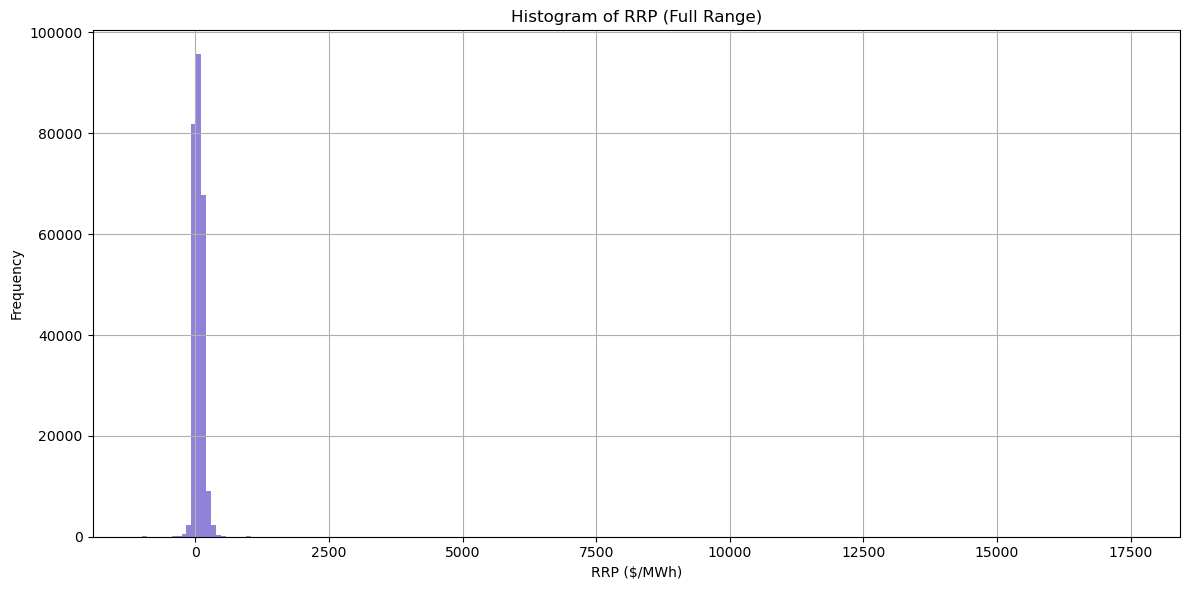

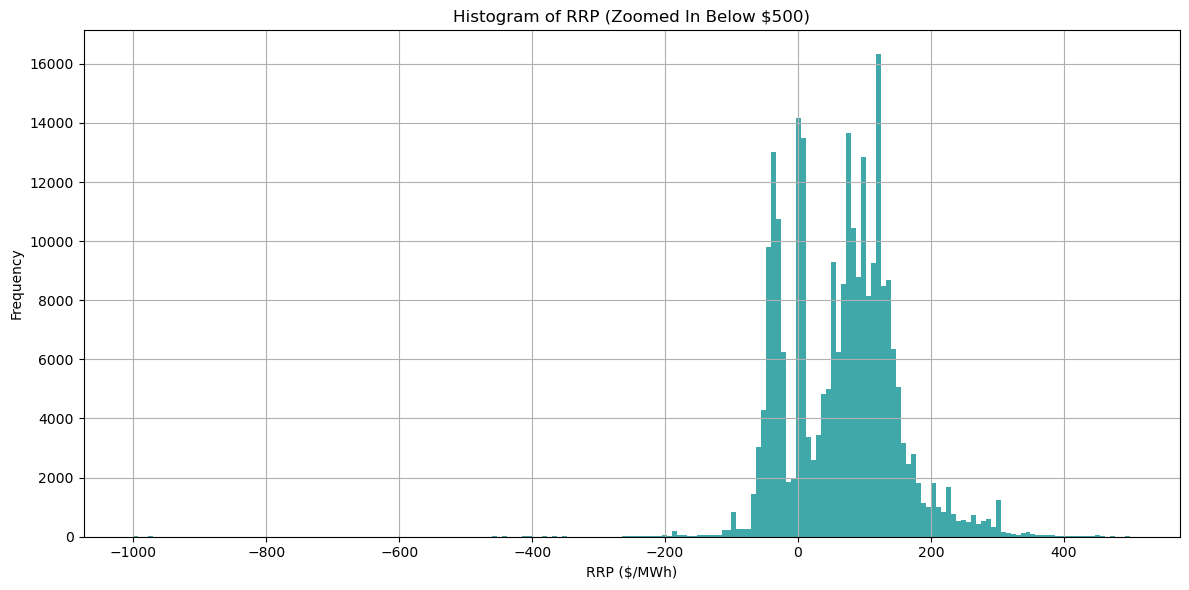

In [8]:
# === Full Range Histogram of RRP ===
plt.figure(figsize=(12, 6))
sns.histplot(df['RRP'], bins=200, color='slateblue', edgecolor=None)
plt.title('Histogram of RRP (Full Range)')
plt.xlabel('RRP ($/MWh)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Zoomed Histogram (below $500) ===
plt.figure(figsize=(12, 6))
sns.histplot(df[df['RRP'] < 500]['RRP'], bins=200, color='darkcyan', edgecolor=None)
plt.title('Histogram of RRP (Zoomed In Below $500)')
plt.xlabel('RRP ($/MWh)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


Daily RRP Distribution (Boxplot)

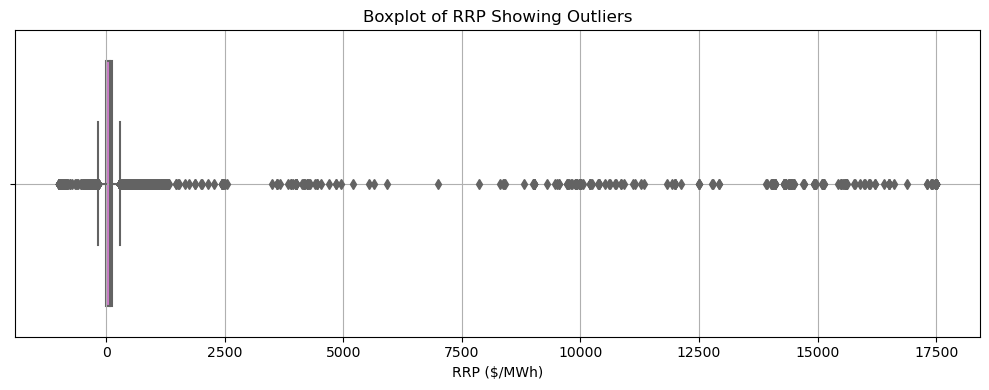

In [9]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['RRP'], color='orchid')
plt.title('Boxplot of RRP Showing Outliers')
plt.xlabel('RRP ($/MWh)')
plt.grid(True)
plt.tight_layout()
plt.show()


Scatter Plots – Renewable Generation vs. RRP

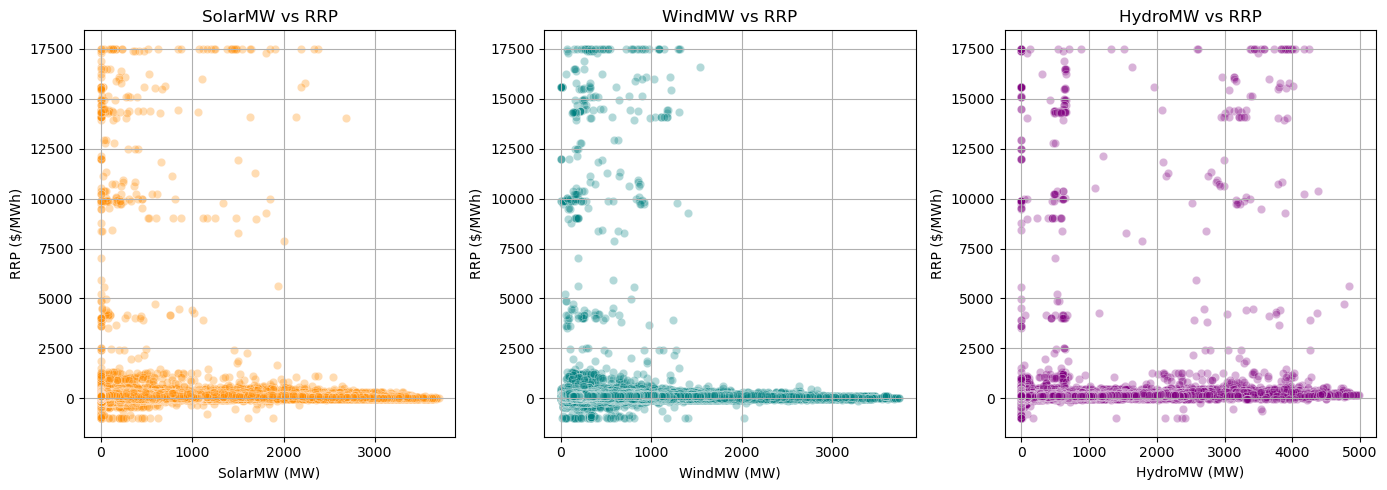

In [10]:
plt.figure(figsize=(14, 5))
colors = ['darkorange', 'teal', 'purple']
for i, col in enumerate(['SolarMW', 'WindMW', 'HydroMW']):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(data=df, x=col, y='RRP', alpha=0.3, color=colors[i])
    plt.title(f'{col} vs RRP')
    plt.xlabel(f'{col} (MW)')
    plt.ylabel('RRP ($/MWh)')
    plt.grid(True)
plt.tight_layout()
plt.show()


Correlation Heatmap

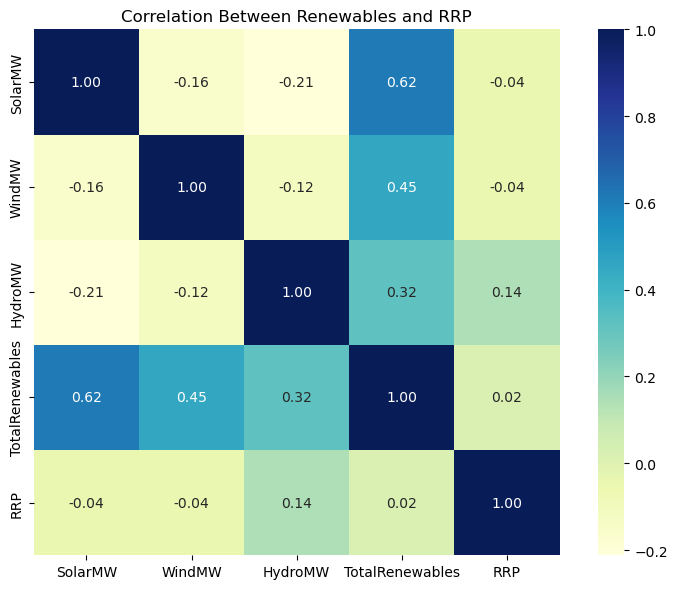

In [11]:
df['TotalRenewables'] = df[['SolarMW', 'WindMW', 'HydroMW']].sum(axis=1)
corr_matrix = df[['SolarMW', 'WindMW', 'HydroMW', 'TotalRenewables', 'RRP']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f", square=True)
plt.title('Correlation Between Renewables and RRP')
plt.tight_layout()
plt.show()


Average Hourly Generation by Fuel Type

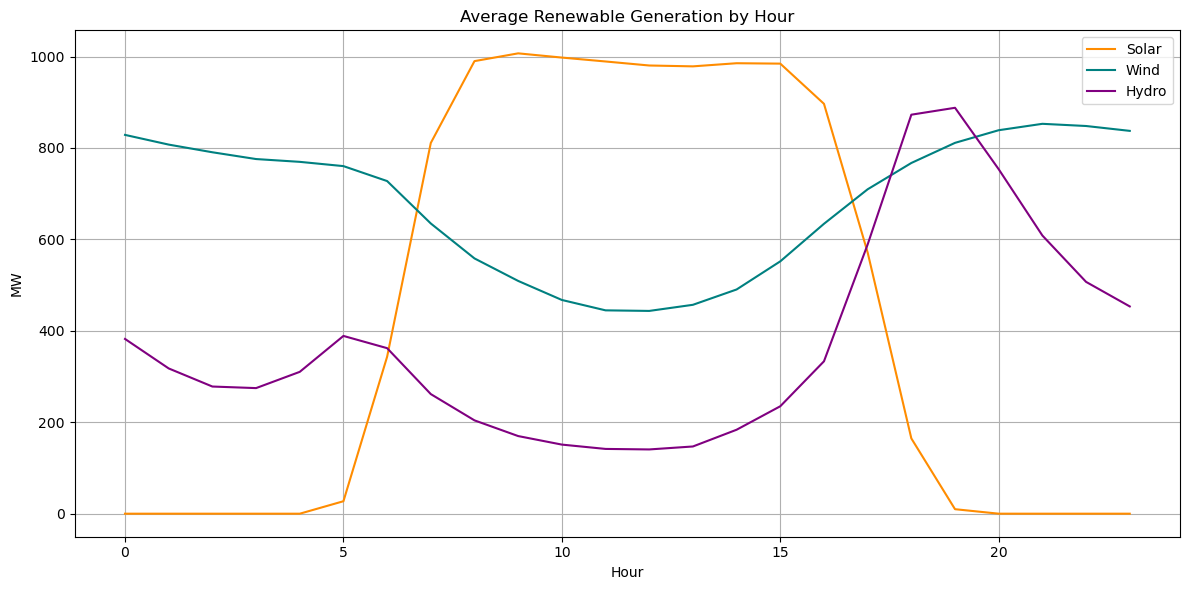

In [12]:
hourly_avg = df.groupby('Hour')[['SolarMW', 'WindMW', 'HydroMW']].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_avg, x='Hour', y='SolarMW', label='Solar', color='darkorange')
sns.lineplot(data=hourly_avg, x='Hour', y='WindMW', label='Wind', color='teal')
sns.lineplot(data=hourly_avg, x='Hour', y='HydroMW', label='Hydro', color='purple')
plt.title('Average Renewable Generation by Hour')
plt.ylabel('MW')
plt.grid(True)
plt.tight_layout()
plt.show()


Average Hourly RRP

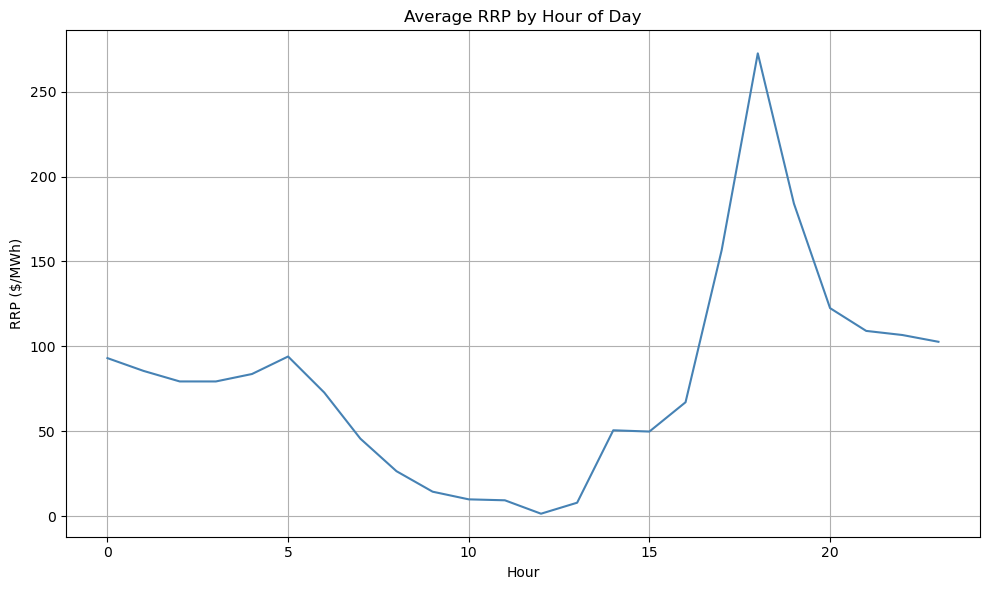

In [13]:
hourly_rrp = df.groupby('Hour')['RRP'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_rrp, x='Hour', y='RRP', color='steelblue')
plt.title('Average RRP by Hour of Day')
plt.ylabel('RRP ($/MWh)')
plt.grid(True)
plt.tight_layout()
plt.show()


Boxplot of RRP by Hour

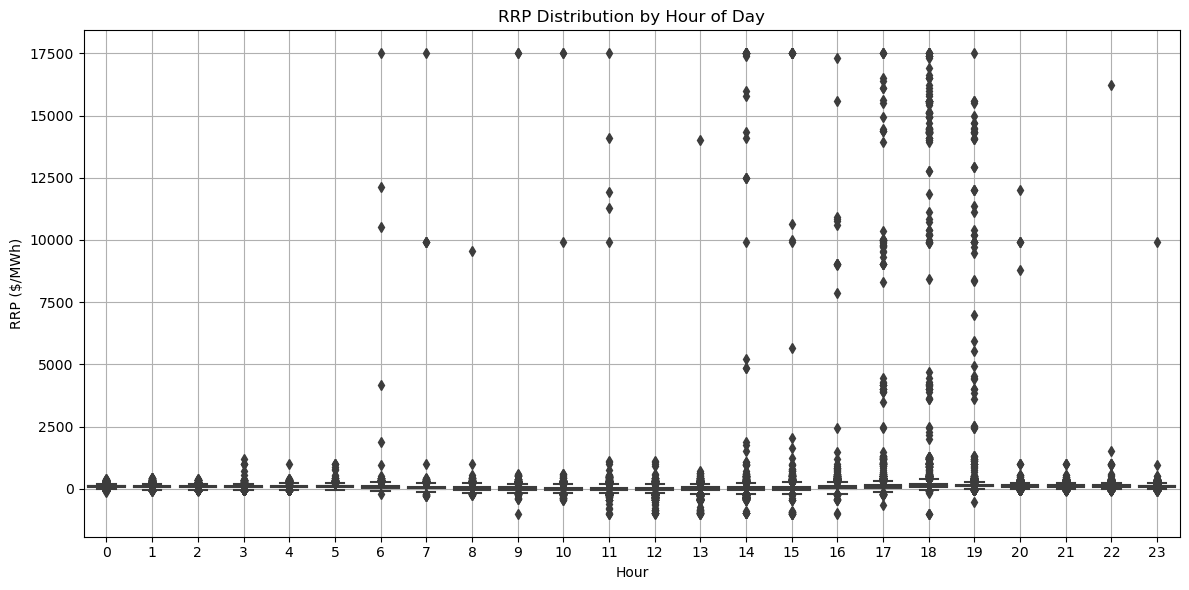

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Hour', y='RRP', palette='muted')
plt.title('RRP Distribution by Hour of Day')
plt.ylabel('RRP ($/MWh)')
plt.grid(True)
plt.tight_layout()
plt.show()


 Boxplot of RRP by Renewable Quartiles

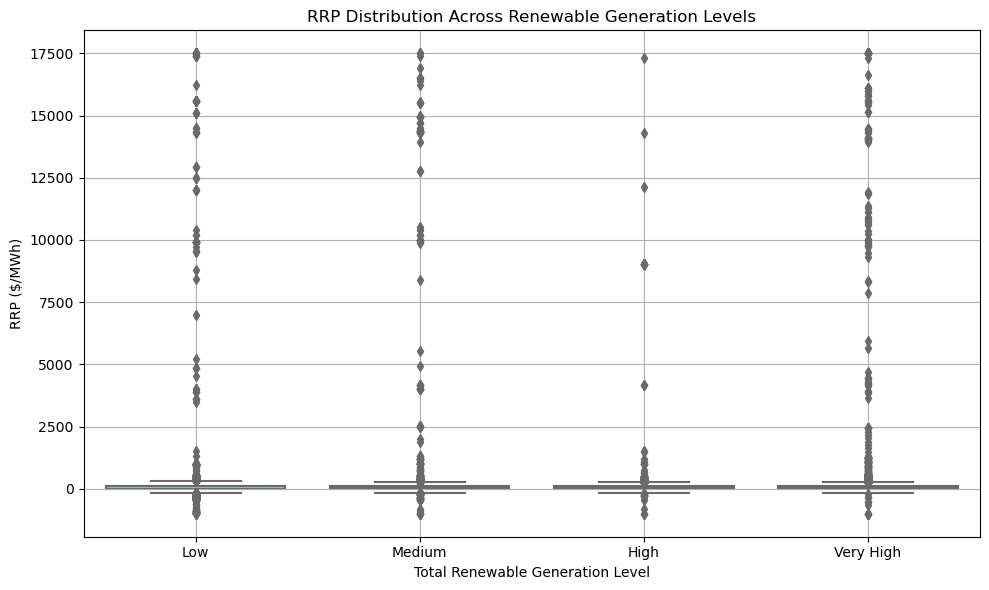

In [15]:
# Create quartile bins
df['RenewableLevel'] = pd.qcut(df['TotalRenewables'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='RenewableLevel', y='RRP', palette='Set3')
plt.title('RRP Distribution Across Renewable Generation Levels')
plt.xlabel('Total Renewable Generation Level')
plt.ylabel('RRP ($/MWh)')
plt.grid(True)
plt.tight_layout()
plt.show()


Statistical Modelling

In [16]:
# Create log-transformed target variable
df['RRP_Log'] = np.log1p(df['RRP'].clip(lower=0))  # handles zero/negatives safely

# Extract time-based features
df['Hour'] = df['SETTLEMENTDATE'].dt.hour
df['DayOfWeek'] = df['SETTLEMENTDATE'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['SETTLEMENTDATE'].dt.month

# Drop missing values (if any)
df_clean = df.dropna(subset=['SolarMW', 'WindMW', 'HydroMW', 'RRP_Log', 'Hour', 'DayOfWeek', 'Month'])

# Select relevant features and target
features = ['SolarMW', 'WindMW', 'HydroMW', 'Hour', 'DayOfWeek', 'Month']
target = 'RRP_Log'

# Final modeling dataset
regression_df = df_clean[features + [target]]

# Optional: Save for later use
regression_df.to_csv('regression_ready_dataset.csv', index=False)

# Display first few rows
print(regression_df.head())


    SolarMW       WindMW      HydroMW  Hour  DayOfWeek  Month   RRP_Log
0  0.023056  1777.561546  1144.108020     0          6      9  4.060443
1  0.272640   244.368680   276.002500     0          6      9  4.582413
2  0.000000  1643.185150     0.000000     0          6      9  0.000000
3  0.000000   247.628740   471.541268     0          6      9  0.000000
4  0.000000  2817.227610     0.000000     0          6      9  0.000000


In [17]:
import statsmodels.api as sm

# Separate features (X) and target (y)
X = regression_df[features]
y = regression_df['RRP_Log']

# Add constant for intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Show the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                RRP_Log   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     9947.
Date:                Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                        21:50:15   Log-Likelihood:            -5.3148e+05
No. Observations:              260687   AIC:                         1.063e+06
Df Residuals:                  260680   BIC:                         1.063e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8758      0.012    316.936      0.0

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare X and y
X = regression_df[features]
y = regression_df['RRP_Log']

# Fit the model
lr = LinearRegression()
lr.fit(X, y)

# Predict and evaluate
y_pred = lr.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


RMSE: 1.8586
R² Score: 0.1863


Prepare NEM-Wide and Region-Specific Time Series for ARIMA

In [19]:
# Step 1: Create log-transformed RRP for modeling
df['RRP_Log'] = np.log1p(df['RRP'].clip(lower=0))

# Step 2: Create NEM-wide time series (average RRP across all regions)
df_nem = df.groupby('SETTLEMENTDATE')['RRP_Log'].mean().reset_index()
df_nem = df_nem.set_index('SETTLEMENTDATE')
ts_nem = df_nem['RRP_Log']
ts_nem.name = 'NEM-wide RRP_Log'

# Step 3: Create region-specific time series (example: QLD1)
region = 'QLD1'
df_region = df[df['Region'] == region].groupby('SETTLEMENTDATE')['RRP_Log'].mean().reset_index()
df_region = df_region.set_index('SETTLEMENTDATE')
ts_region = df_region['RRP_Log']
ts_region.name = f'{region} RRP_Log'

# Preview first few values (optional)
print(ts_nem.head())
print(ts_region.head())


SETTLEMENTDATE
2024-09-01 00:05:00    1.728571
2024-09-01 00:10:00    1.728571
2024-09-01 00:15:00    1.728571
2024-09-01 00:20:00    1.676642
2024-09-01 00:25:00    1.685343
Name: NEM-wide RRP_Log, dtype: float64
SETTLEMENTDATE
2024-09-01 00:05:00    4.582413
2024-09-01 00:10:00    4.582413
2024-09-01 00:15:00    4.582413
2024-09-01 00:20:00    4.368815
2024-09-01 00:25:00    4.366278
Name: QLD1 RRP_Log, dtype: float64


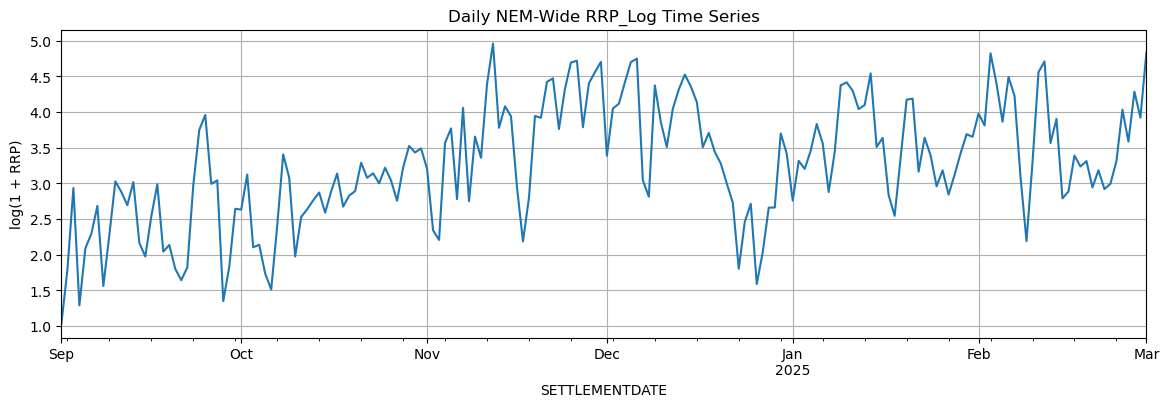

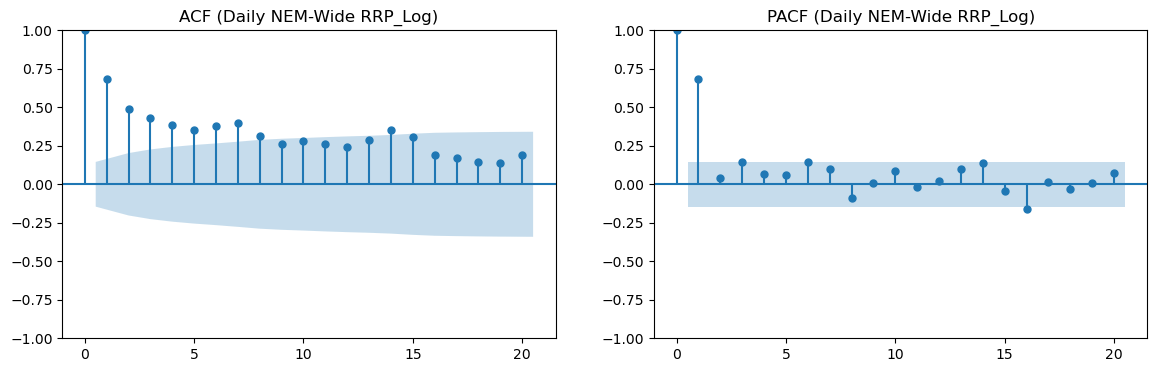

ADF Test Results:
Test Statistic: -5.7339558774934805
p-value: 6.503089889896885e-07
Lags Used: 0
Number of Observations: 181
Critical Values: {'1%': -3.467004502498507, '5%': -2.8776444997243558, '10%': -2.575355189707274}


In [20]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Resample NEM-wide RRP_Log to daily average
ts_nem_daily = ts_nem.resample('D').mean().dropna()

# ADF Test
adf_result = adfuller(ts_nem_daily)
adf_summary = {
    'Test Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Lags Used': adf_result[2],
    'Number of Observations': adf_result[3],
    'Critical Values': adf_result[4]
}

# Plot daily time series
plt.figure(figsize=(14, 4))
ts_nem_daily.plot(title='Daily NEM-Wide RRP_Log Time Series')
plt.ylabel('log(1 + RRP)')
plt.grid(True)
plt.show()

# Plot ACF and PACF (reduced lags)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(ts_nem_daily, ax=axes[0], lags=20)
plot_pacf(ts_nem_daily, ax=axes[1], lags=20, method='ywm')
axes[0].set_title('ACF (Daily NEM-Wide RRP_Log)')
axes[1].set_title('PACF (Daily NEM-Wide RRP_Log)')
plt.show()

# Output ADF test results
print("ADF Test Results:")
for k, v in adf_summary.items():
    print(f"{k}: {v}")


In [21]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [22]:
from pmdarima import auto_arima

model_auto = auto_arima(ts_nem_daily, 
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        seasonal=False,
                        stepwise=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True)

print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=355.603, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=352.406, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=345.938, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=353.798, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=325.892, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=326.767, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=326.610, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=327.883, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=343.258, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=325.679, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=344.323, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=350.647, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=326.239, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=326.125, 

Forecasting and Plotting (with Confidence Intervals)

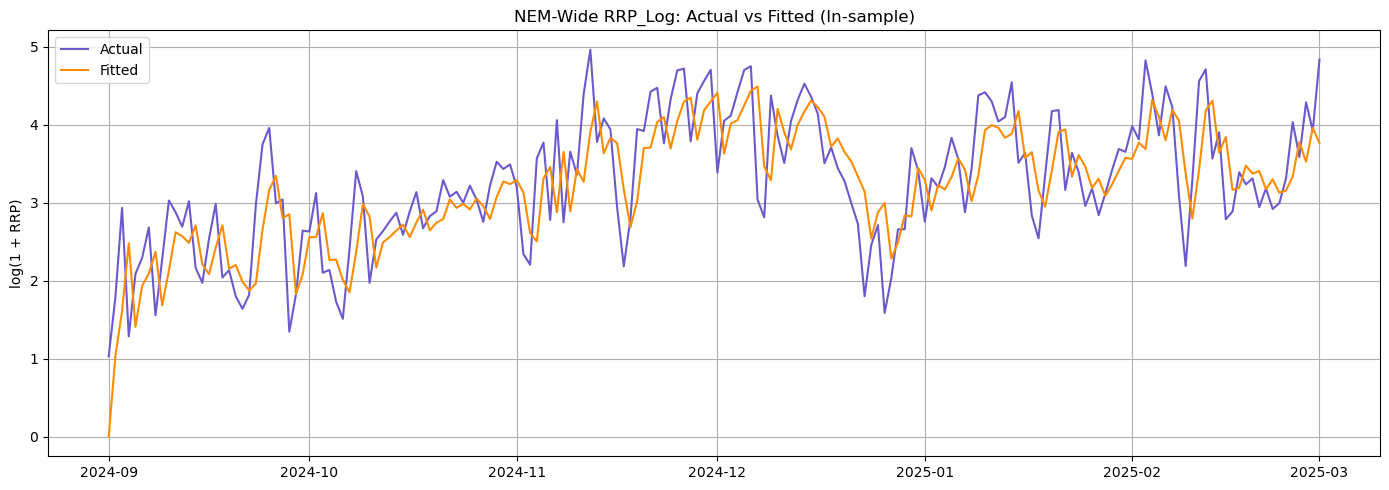

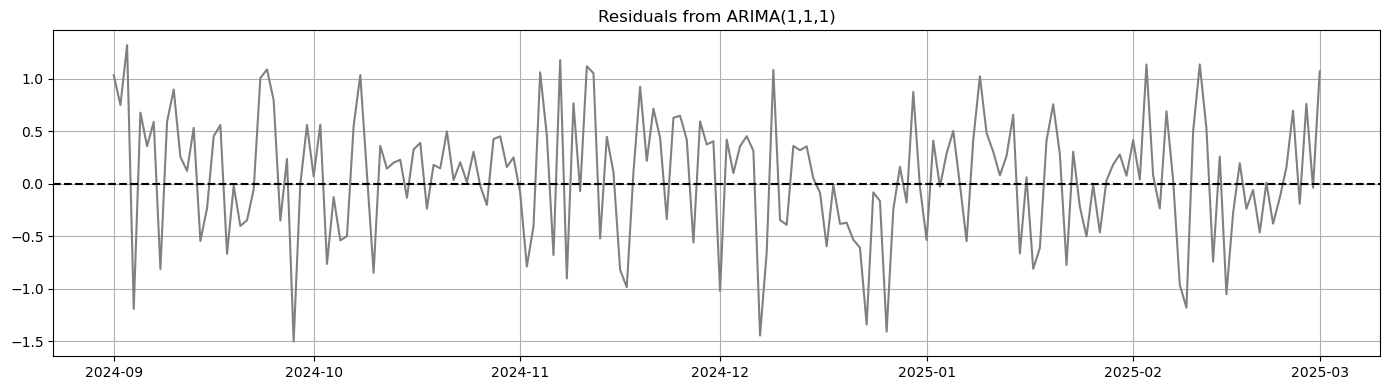

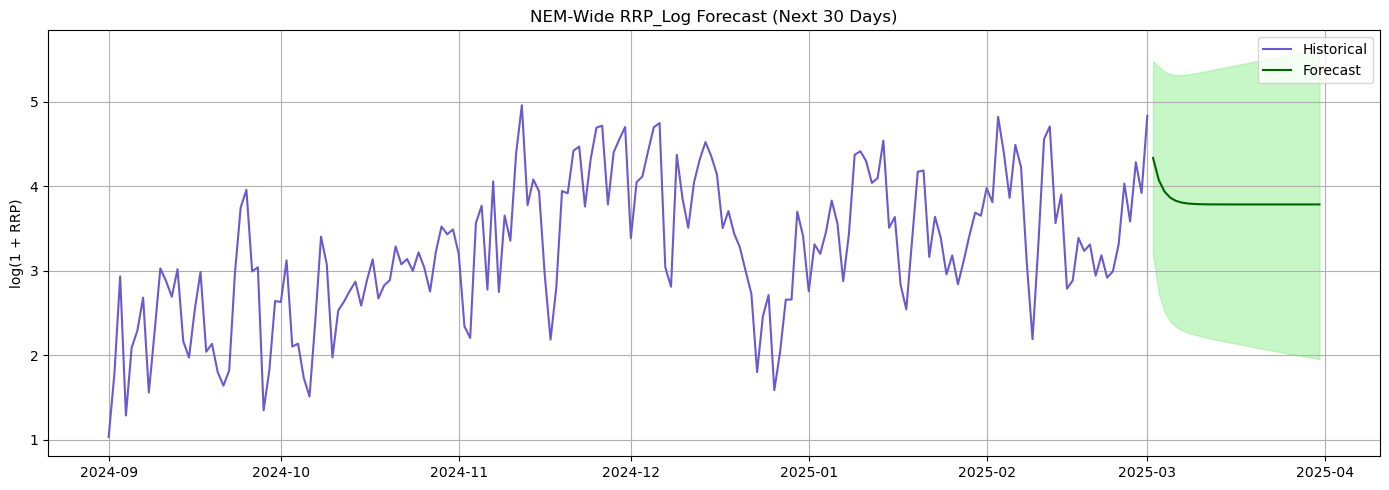

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

df = pd.read_csv("scada_price_fueltype_cleaned.csv", parse_dates=['SETTLEMENTDATE'])
df['RRP_Log'] = np.log1p(df['RRP'].clip(lower=0))

# Create NEM-wide daily time series
ts_nem_daily = df.groupby('SETTLEMENTDATE')['RRP_Log'].mean().resample('D').mean().dropna()

# Fit ARIMA(1,1,1)
model = SARIMAX(ts_nem_daily, order=(1, 1, 1))
model_fit = model.fit(disp=False)

# === In-sample Actual vs Fitted ===
fitted_values = model_fit.fittedvalues
plt.figure(figsize=(14, 5))
plt.plot(ts_nem_daily, label='Actual', color='slateblue')
plt.plot(fitted_values, label='Fitted', color='darkorange')
plt.title('NEM-Wide RRP_Log: Actual vs Fitted (In-sample)')
plt.ylabel('log(1 + RRP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Residuals Plot ===
residuals = ts_nem_daily - fitted_values
plt.figure(figsize=(14, 4))
plt.plot(residuals, label='Residuals', color='gray')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuals from ARIMA(1,1,1)')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Forecast Next 30 Days ===
n_forecast = 30
forecast_result = model_fit.get_forecast(steps=n_forecast)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Prepare forecast data for plotting
forecast_index = pd.to_datetime(forecast_mean.index)
forecast_values = forecast_mean.values.astype(float)
lower_bound = conf_int.iloc[:, 0].astype(float).values
upper_bound = conf_int.iloc[:, 1].astype(float).values

plt.figure(figsize=(14, 5))
plt.plot(ts_nem_daily, label='Historical', color='slateblue')
plt.plot(forecast_index, forecast_values, label='Forecast', color='darkgreen')
plt.fill_between(forecast_index, lower_bound, upper_bound, color='lightgreen', alpha=0.5)
plt.title('NEM-Wide RRP_Log Forecast (Next 30 Days)')
plt.ylabel('log(1 + RRP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ML Models

In [24]:

# Create log-transformed target
df['RRP_Log'] = np.log1p(df['RRP'].clip(lower=0))

#  Extract time-based features
df['Hour'] = df['SETTLEMENTDATE'].dt.hour
df['DayOfWeek'] = df['SETTLEMENTDATE'].dt.dayofweek
df['Month'] = df['SETTLEMENTDATE'].dt.month

#  Prepare regression-ready dataset
features = ['SolarMW', 'WindMW', 'HydroMW', 'Hour', 'DayOfWeek', 'Month']
target = 'RRP_Log'
df_clean = df.dropna(subset=features + [target])
regression_df = df_clean[features + [target]]

# Train-test split
X = regression_df[features]
y = regression_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"Random Forest R² Score: {r2_rf:.4f}")


Random Forest RMSE: 0.7586
Random Forest R² Score: 0.8640


Random Forest Feature Importance

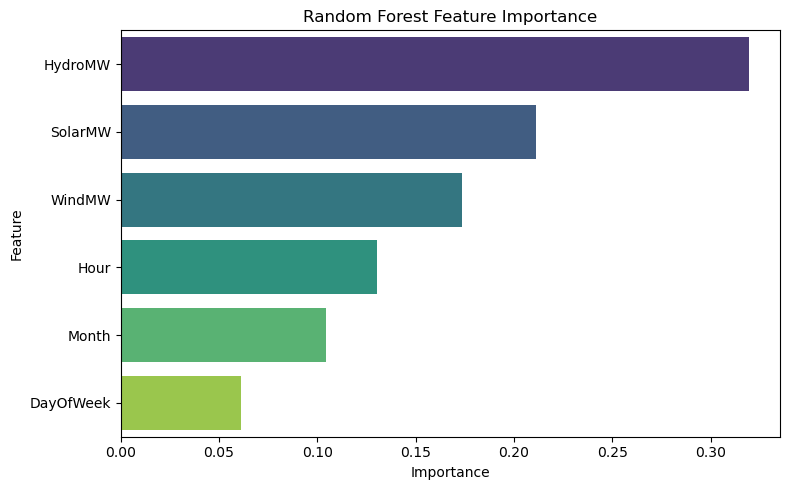

In [25]:
# Get feature importances
importances_rf = rf_model.feature_importances_
features = X_train.columns
rf_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_rf})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=rf_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


XGBoost model

In [26]:
from xgboost import XGBRegressor

# Create log-transformed target variable
df['RRP_Log'] = np.log1p(df['RRP'].clip(lower=0))

# Create time-based features
df['Hour'] = df['SETTLEMENTDATE'].dt.hour
df['DayOfWeek'] = df['SETTLEMENTDATE'].dt.dayofweek
df['Month'] = df['SETTLEMENTDATE'].dt.month

# Prepare features and target
features = ['SolarMW', 'WindMW', 'HydroMW', 'Hour', 'DayOfWeek', 'Month']
target = 'RRP_Log'
df_clean = df.dropna(subset=features + [target])

X = df_clean[features]
y = df_clean[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit XGBoost Regressor (full complexity)
xgb_model = XGBRegressor(
    n_estimators=200,         # More trees
    max_depth=6,              # Deeper trees
    learning_rate=0.1,
    subsample=1.0,            # Use all data per tree
    colsample_bytree=1.0,     # Use all features per tree
    random_state=42,
    verbosity=1,
    n_jobs=-1                 # Use all CPU cores
)

xgb_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {rmse:.4f}")
print(f"XGBoost R² Score: {r2:.4f}")


XGBoost RMSE: 1.0692
XGBoost R² Score: 0.7298


XGBoost Feature Importance

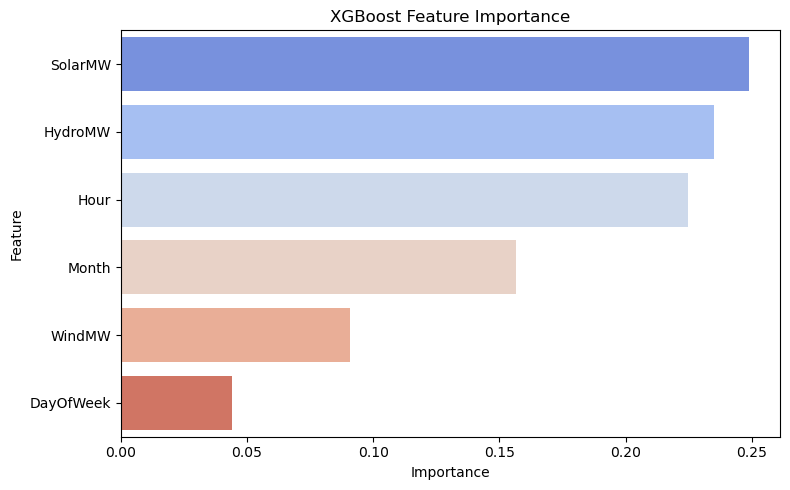

In [27]:
importances_xgb = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_xgb})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=xgb_importance_df, x='Importance', y='Feature', palette='coolwarm')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


Gradient Boosting Regressor 

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

# Load and preprocess data
df = pd.read_csv("scada_price_fueltype_cleaned.csv", parse_dates=['SETTLEMENTDATE'])
df['RRP_Log'] = np.log1p(df['RRP'].clip(lower=0))
df['Hour'] = df['SETTLEMENTDATE'].dt.hour
df['DayOfWeek'] = df['SETTLEMENTDATE'].dt.dayofweek
df['Month'] = df['SETTLEMENTDATE'].dt.month

features = ['SolarMW', 'WindMW', 'HydroMW', 'Hour', 'DayOfWeek', 'Month']
target = 'RRP_Log'
df_clean = df.dropna(subset=features + [target])

X = df_clean[features]
y = df_clean[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbr_model.fit(X_train, y_train)

#  Evaluate
y_pred_gbr = gbr_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2 = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting RMSE: {rmse:.4f}")
print(f"Gradient Boosting R² Score: {r2:.4f}")


Gradient Boosting RMSE: 1.3107
Gradient Boosting R² Score: 0.5940


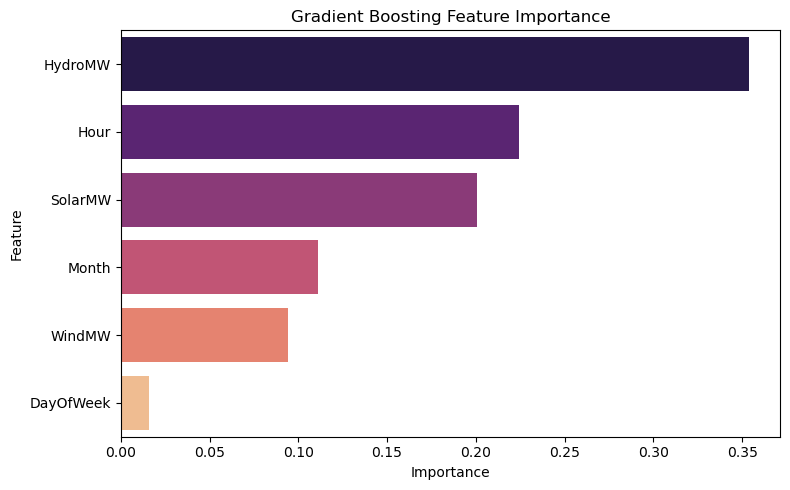

In [29]:

# Get feature importances from trained model
importances_gbr = gbr_model.feature_importances_
features = X_train.columns
gbr_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_gbr})
gbr_importance_df = gbr_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(data=gbr_importance_df, x='Importance', y='Feature', palette='magma')
plt.title('Gradient Boosting Feature Importance')
plt.tight_layout()
plt.show()


Residual Analysis

Actual vs Predicted Scatter Plot for All 3 Models

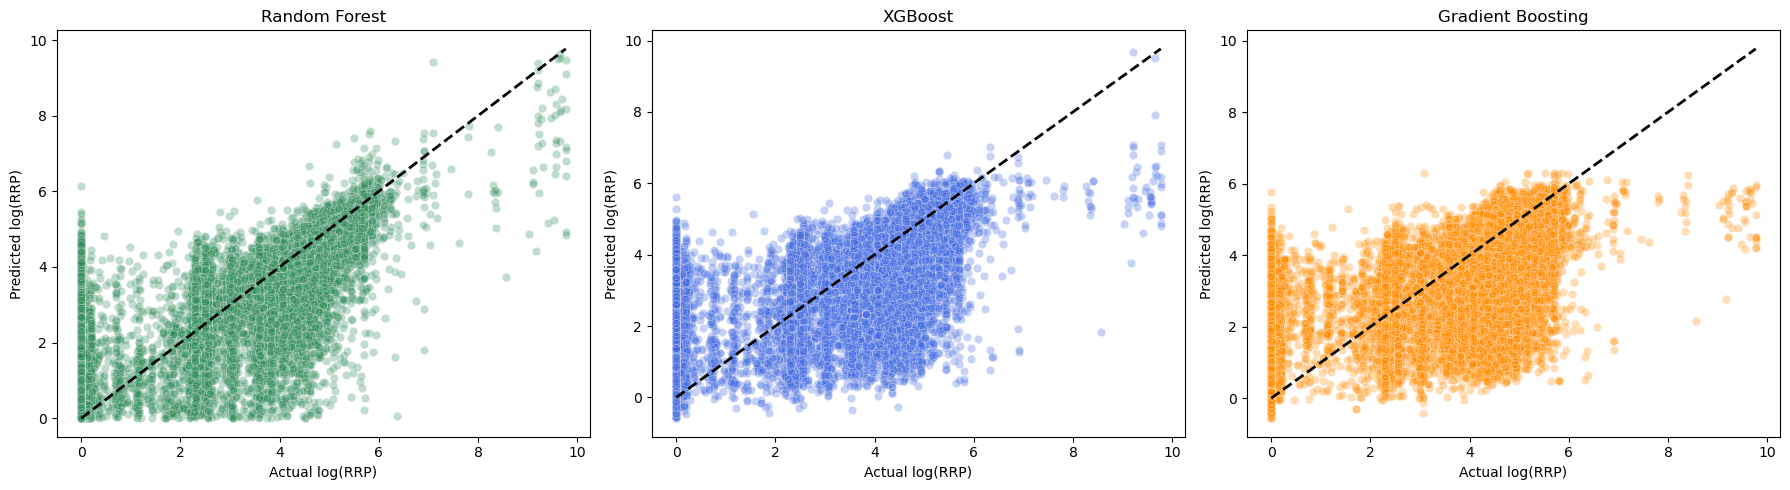

In [30]:
plt.figure(figsize=(18, 5))

# Random Forest
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3, color='seagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual log(RRP)')
plt.ylabel('Predicted log(RRP)')
plt.title('Random Forest')

# XGBoost
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual log(RRP)')
plt.ylabel('Predicted log(RRP)')
plt.title('XGBoost')

# Gradient Boosting
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_gbr, alpha=0.3, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual log(RRP)')
plt.ylabel('Predicted log(RRP)')
plt.title('Gradient Boosting')

plt.tight_layout()
plt.show()


Residual Plot for Random Forest

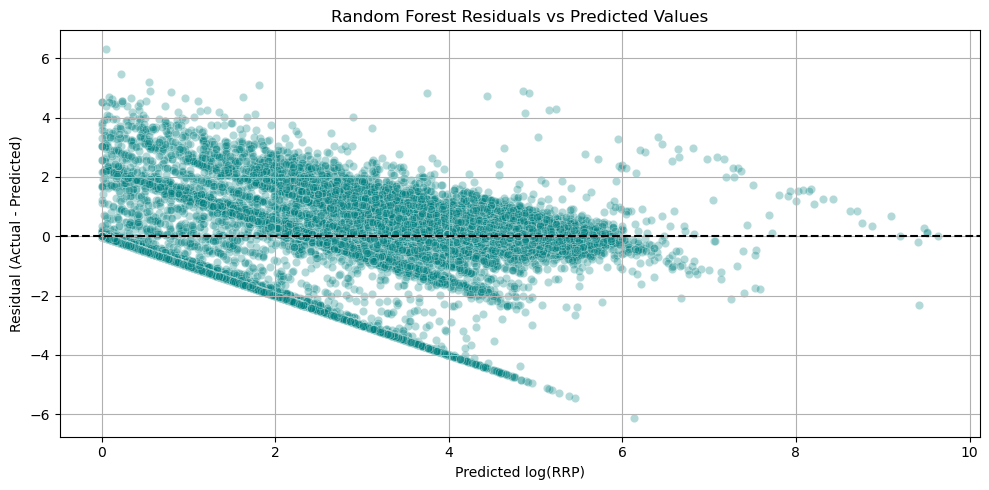

In [31]:

# Calculate residuals
residuals_rf = y_test - y_pred_rf

# Plot residuals vs predicted
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred_rf, y=residuals_rf, alpha=0.3, color='teal')
plt.axhline(0, linestyle='--', color='black')
plt.title('Random Forest Residuals vs Predicted Values')
plt.xlabel('Predicted log(RRP)')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()


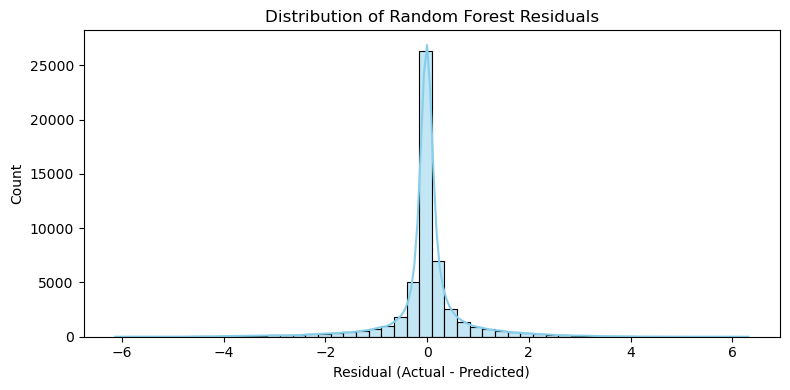

In [32]:
# Histogram of residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals_rf, kde=True, bins=50, color='skyblue')
plt.title('Distribution of Random Forest Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.tight_layout()
plt.show()


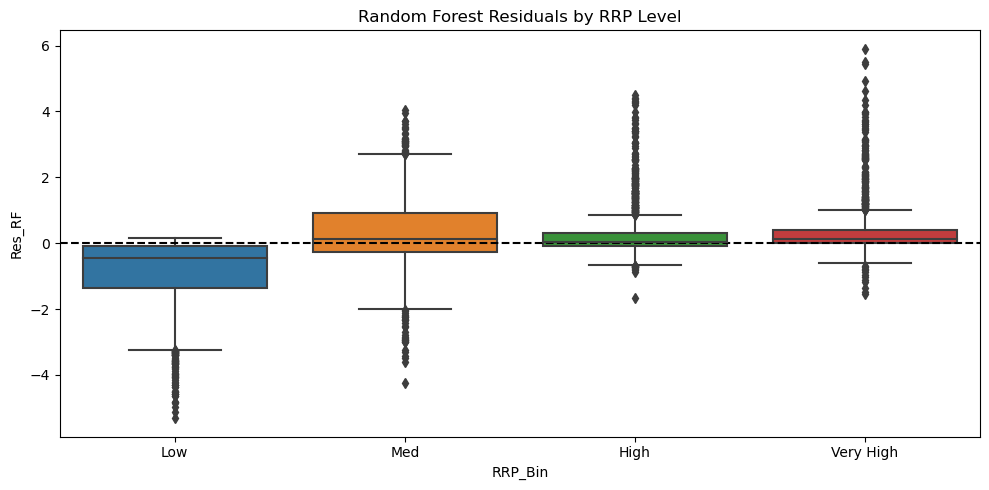

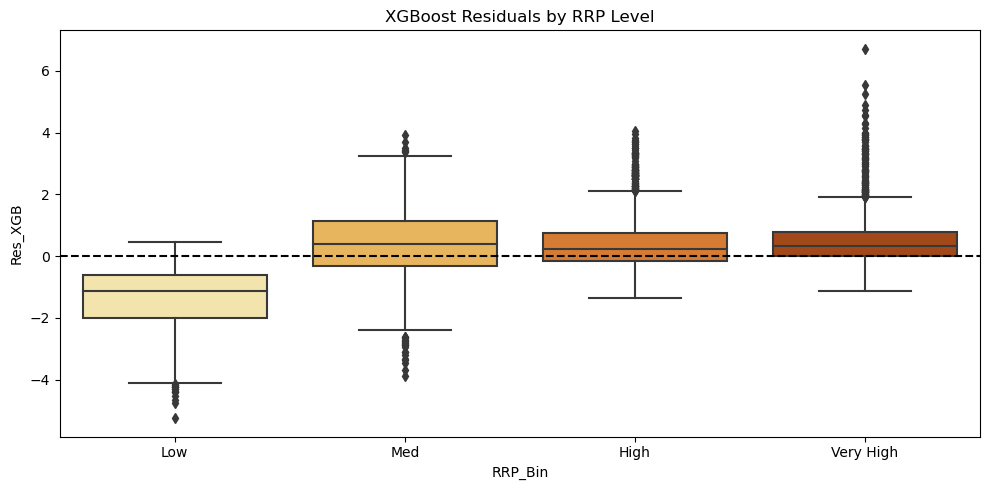

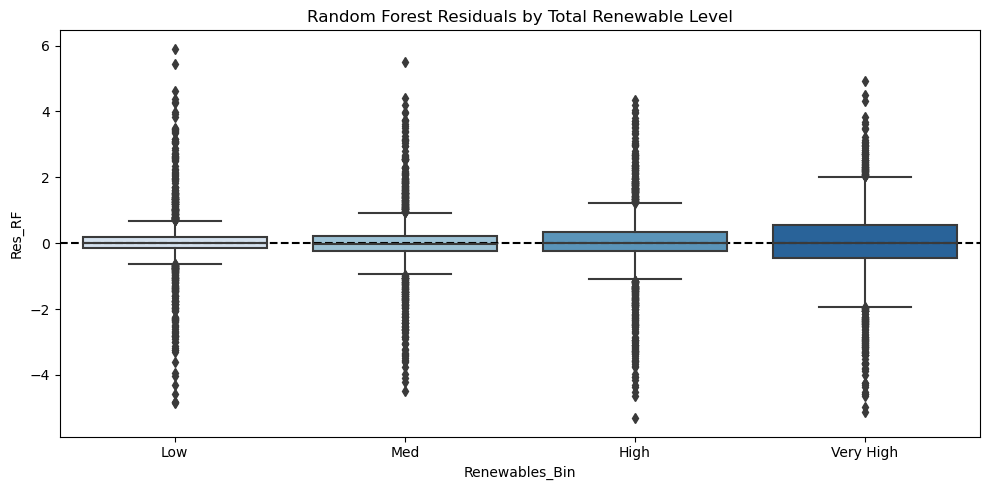

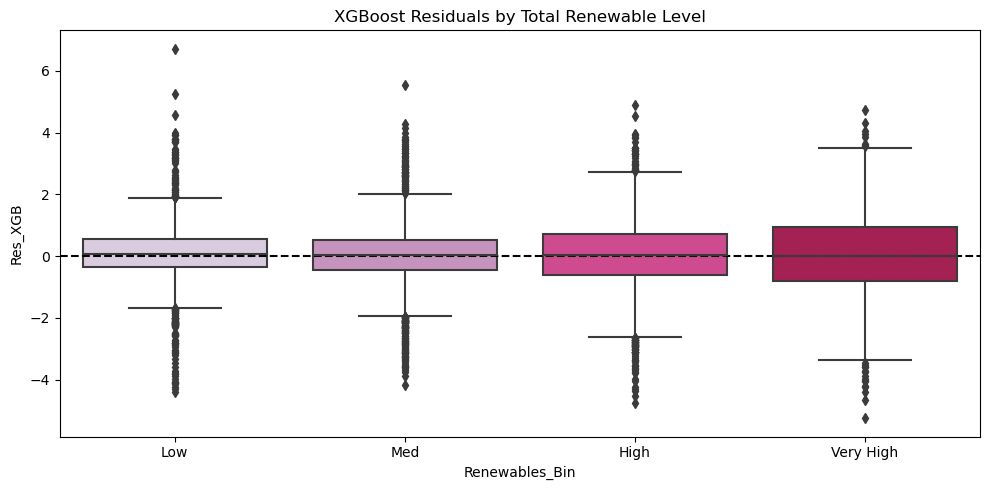

In [33]:

# Load and preprocess data
df = pd.read_csv("scada_price_fueltype_cleaned.csv", parse_dates=['SETTLEMENTDATE'])
df['RRP_Log'] = np.log1p(df['RRP'].clip(lower=0))
df['Hour'] = df['SETTLEMENTDATE'].dt.hour
df['DayOfWeek'] = df['SETTLEMENTDATE'].dt.dayofweek
df['Month'] = df['SETTLEMENTDATE'].dt.month
df = df.dropna(subset=['SolarMW', 'WindMW', 'HydroMW', 'RRP_Log'])

# Optional: sample down to speed up training
df_sampled = df.sample(n=30000, random_state=42)

# Prepare data
features = ['SolarMW', 'WindMW', 'HydroMW', 'Hour', 'DayOfWeek', 'Month']
X = df_sampled[features]
y = df_sampled['RRP_Log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

xgb_model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Residuals
res_rf = y_test - y_pred_rf
res_xgb = y_test - y_pred_xgb

# For plotting
results_df = X_test.copy()
results_df['RRP'] = np.expm1(y_test)
results_df['Res_RF'] = res_rf
results_df['Res_XGB'] = res_xgb
results_df['TotalRenewables'] = results_df[['SolarMW', 'WindMW', 'HydroMW']].sum(axis=1)

# Create bins
results_df['RRP_Bin'] = pd.qcut(results_df['RRP'], 4, labels=['Low', 'Med', 'High', 'Very High'])
results_df['Renewables_Bin'] = pd.qcut(results_df['TotalRenewables'], 4, labels=['Low', 'Med', 'High', 'Very High'])

# Plot 1: RF Residuals by RRP Level
plt.figure(figsize=(10, 5))
sns.boxplot(data=results_df, x='RRP_Bin', y='Res_RF')
plt.axhline(0, linestyle='--', color='black')
plt.title("Random Forest Residuals by RRP Level")
plt.tight_layout()
plt.show()

# Plot 2: XGB Residuals by RRP Level
plt.figure(figsize=(10, 5))
sns.boxplot(data=results_df, x='RRP_Bin', y='Res_XGB', palette='YlOrBr')
plt.axhline(0, linestyle='--', color='black')
plt.title("XGBoost Residuals by RRP Level")
plt.tight_layout()
plt.show()

# Plot 3: RF Residuals by Total Renewables
plt.figure(figsize=(10, 5))
sns.boxplot(data=results_df, x='Renewables_Bin', y='Res_RF', palette='Blues')
plt.axhline(0, linestyle='--', color='black')
plt.title("Random Forest Residuals by Total Renewable Level")
plt.tight_layout()
plt.show()

# Plot 4: XGB Residuals by Total Renewables
plt.figure(figsize=(10, 5))
sns.boxplot(data=results_df, x='Renewables_Bin', y='Res_XGB', palette='PuRd')
plt.axhline(0, linestyle='--', color='black')
plt.title("XGBoost Residuals by Total Renewable Level")
plt.tight_layout()
plt.show()
